# Processing AIS Logs

## Summary

This chapter will cover how to extract information about the course and track of **other** boats and display alongside our internal logs.

[Automatic Identification System](https://en.wikipedia.org/wiki/Automatic_identification_system) (AIS): *AIS integrates a standardized VHF transceiver with a positioning system such as a Global Positioning System receiver, with other electronic navigation sensors, such as a gyrocompass or rate of turn indicator.*  Typically messages including lat/lon/COG/SOG are sent every 30 seconds.

[Maritime Mobile Service Identity](https://en.wikipedia.org/wiki/Maritime_Mobile_Service_Identity) (MMSI): *A Maritime Mobile Service Identity (MMSI) is a series of nine digits which are sent in digital form over a radio frequency channel in order to uniquely identify ship stations, ship earth stations, coast stations, coast earth stations, and group calls.*

Below is an image of a sail track extracted from the AIS logs.

![im](Data/Images/ais_chart.png)


## Setup

Recently did a tune up match versus another boat.  Both boats typically upload to RaceQs, and later using RaceQs mapping and replay features we can get a better sense of who was sailing higher and/or faster.  But this time the other boat had a technical issue and **could not run RaceQs**.

I was a bit sad to miss out on this data, but then it hit me.  We have data on the other boat in our logs, specifically because they use an AIS transponder.

Note, I currently "run" RaceQs by processing the Canboat logs and then generating a GPX file.  I upload this GPX file to the RaceQs site, and it works great. I do not run the RaceQs app.  Its been a bit unreliable, and it is limited by the quality of the GPS in my phone.  Since I am using the GPS on my boat instead (which has a receiver the size of my fist), I get much higher quality tracks and it is much more reliable. In principle, I could do the same for another boat, as long as I had information about lat/lon versus time.

One of the devices on my NMEA network is a fancy [V50 B&G Radio](https://www.bandg.com/bg/type/vhf-ais/vhf-marine-radiov50/).  The V50 handles sending and receiving of AIS messages.  It sends these AIS fixes over NMEA 2k to my chartplotter and they magically appear (in an annoying BandG interface).

Because we log every NMEA 2K message, AIS fixes are part of my log, **for every boat that is using AIS within range.**

There are 4 AIS messages that I've seen on my 2K network:

            (129039, "AIS Class B Position Report"),
            (129809, "AIS Class B static data (msg 24 Part A)"),
            (129810, "AIS Class B static data (msg 24 Part B)"),
            (130842, "Simnet: AIS Class B static data (msg 24 Part A)")

PGN 130842 seems to be a duplicate of 129809 and 129810 (I suspect this is a BandG thing, since BandG merged with Simrad).  

Most info is sent in **PGN 129039**.  These appear every 30 seconds or so, and include lat/lon/COG/SOG:

    {"timestamp":"2020-04-01T12:15:30.816Z","prio":4,"src":8,"dst":255,"pgn":129039,"description":"AIS Class B Position Report","fields":{"Message ID":18,"Repeat Indicator":"Initial","User ID":338056811,"Longitude":-122.4130630,"Latitude":47.6858215,"Position Accuracy":"High","RAIM":"in use","Time Stamp":"4","COG":242.4,"SOG":3.24,"Communication State":"3","AIS Transceiver information":"Channel B VDL reception","Regional Application":0,"Regional Application":0,"Unit type":"CS","Integrated Display":"Yes","DSC":"Yes","Band":"entire marine band","Can handle Msg 22":"Yes","AIS mode":"Assigned","AIS communication state":"ITDMA"}}

Note, there is no GPS timestamp nor info on the **name** of the boat, just the `User ID` which turns out to be the.  (The timestamp is from the RPi and it is wrong.)

Info on the craft name is in **PGN 129809**:

    {"timestamp":"2020-04-01T12:22:52.186Z","prio":6,"src":8,"dst":255,"pgn":129809,"description":"AIS Class B static data (msg 24 Part A)","fields":{"Message ID":24,"Repeat indicator":"Initial","User ID":338056811,"Name":"CREATIVE"}}

Info on craft size is in **PGN 129810**.  This is super helpful when avoiding container ships and cruise liners, not useful for racing.

    {"timestamp":"2020-04-01T12:23:03.273Z","prio":6,"src":8,"dst":255,"pgn":129810,"description":"AIS Class B static data (msg 24 Part B)","fields":{"Message ID":24,"Repeat indicator":"Initial","User ID":338056811,"Type of ship":"Sailing","Vendor ID":"}BT  ","Callsign":"","Length":10.0,"Beam":4.0,"Position reference from Starboard":3.0,"Position reference from Bow":4.0,"Mothership User ID":0,"Spare":0}}

## Challenges

1. Retrieving the correct set of records based on craft name of MMSI (aka User ID).
1. Getting GPS time for the lat/lon fixes.
1. Converting to Pandas.
1. Writing the GPX file.

We will focus on two AIS messages:

    (129039, "AIS Class B Position Report"),
    (129809, "AIS Class B static data (msg 24 Part A)"),
    
The first has lat/lon and timing, the second craft name.  In addition we will extract GPS time from:

    (129029, 'GNSS Position Data'),
    
We'll collect all the messages of each type and stuff them into two different dataframes.  The only trick is to get the correct times.  We'll do a "best effort" job and simply capture the most recent GPS time message and use it to determine the GPS time as well as the (incorrect) system time.  (Recall that the system time, aka RPi time, is not correct.)

**Note,** this code is in `ais_process.py`.

In [46]:
# Load some libraries
%matplotlib notebook
from IPython.display import display, Markdown, Latex

import global_variables
G = global_variables.init_seattle()

*some markdown* $\phi$

In [40]:
import logging
import copy
import itertools as it
import datetime

import numpy as np
import scipy
import scipy.interpolate
import pandas as pd
import arrow

import global_variables
G = global_variables.init_seattle()

import canboat as cb
import chart as c
import process as p

# Helpful constancts for NMEA 2K PGNs
PGN_GNSS         = cb.pgn_code('GNSS Position Data')
PGN_AIS_POSITION = 129039  # AIS Class B Position Report
PGN_AIS_DATA     = 129809  # AIS Class B static data (msg 24 Part A)

NMEA_SRC         = 8  # V50 radio

MIN_DELTA_TIME = datetime.timedelta(microseconds = 10000) # 10 milliseconds

def ais_dataframes(records):
    "Return two dataframes, one that records the positions of all AIS craft.  The second that records the names."
    # The only thing that makes this a bit tricky is getting the correct GPS times.  The
    # row timestamps are incorrect, so we need to wait for a GNSS record to go by, and
    # then determines the true GPS time.
    pgns_to_collect = {PGN_AIS_POSITION, PGN_AIS_DATA}
    pgn_rows = {k:[] for k in pgns_to_collect}
    delta_time = None
    for record_num, record in zip(it.count(), records):
        if record_num % 500000 == 0:
            logging.info(f"Processed {record_num} json lines.")
        pgn = record['pgn']
        src = record['src']
        if delta_time is None and pgn == PGN_GNSS:
            # Row time (from Raspberry PI)
            timestamp = arrow.get(record['timestamp'])
            # GPS time, from the GNSS record.
            gnss_datetime = cb.convert_gnss_date_time(record['fields']['Date'],
                                                      record['fields']['Time'])
            
            # difference between the two clocks
            delta_time = gnss_datetime - timestamp
            previous_timestamp = timestamp
            logging.info(f"Found GNSS record at {gnss_datetime}")
            logging.info(f"Delta time is {delta_time}.")
        elif (pgn in pgns_to_collect) and (delta_time is not None): 
            # Wait until we've seen at least one GNSS message
            row = copy.copy(record['fields'])
            timestamp = arrow.get(record['timestamp'])
            # Had a weird special cases where the same timestamp appeared twice.  Let's just skip.
            if (timestamp - previous_timestamp) > MIN_DELTA_TIME:
                previous_timestamp = timestamp
                row['src'] = src
                row['timestamp'] = timestamp.datetime
                row['row_times'] = (timestamp + delta_time).datetime
                pgn_rows[pgn].append(row)
    res = {}
    for pgn, rows in pgn_rows.items():
        df = pd.DataFrame(rows)
        # Rename columns so that they make sense
        res[pgn] = df.rename(columns=cb.canonical_field_name)
    return res

def json_to_ais_data_frame(json_file, max_rows=None):
    "Read the JSON log file and produce a dataframe contains all lat/lon fixes contained in the AIS logs."
    records = cb.json_records( cb.file_lines(json_file), None, 1)
    records = it.islice(records, 0, max_rows)

    dfs = ais_dataframes(records)

    df_pos = dfs[PGN_AIS_POSITION]
    # Just grab the critical columns, and then remove dups
    df_data = dfs[PGN_AIS_DATA][['user_id', 'name']].drop_duplicates()
    # Join the two dataframes, adds the name column to the position data
    df_joined = df_pos.merge(df_data, on='user_id')
    # Sort by row_times, seems natural
    return df_joined.sort_values(by=['row_times'])


In [41]:
json_path = p.json_from_matching_named_file("2020-03-07")
# json_path = p.json_from_matching_named_file("2020-04-16")

df_all = json_to_ais_data_frame(json_path, None)  # 100000)
bdf = df_all[df_all.name=='SONIC']


2020-04-17 10:28:06,391|INFO|json_from_named_file| 2020-03-07_09:28.log.gz: Creating JSON
2020-04-17 10:28:06,392|INFO|json_from_named_file| File /tmp/2020-03-07_09:28.json exists, skipping.
2020-04-17 10:28:06,393|INFO|ais_dataframes| Processed 0 json lines.
2020-04-17 10:28:06,394|INFO|ais_dataframes| Found GNSS record at 2020-03-07T17:28:54+00:00
2020-04-17 10:28:06,394|INFO|ais_dataframes| Delta time is 15:11:46.785000.
2020-04-17 10:28:09,541|INFO|ais_dataframes| Processed 500000 json lines.
2020-04-17 10:28:12,684|INFO|ais_dataframes| Processed 1000000 json lines.
2020-04-17 10:28:15,926|INFO|ais_dataframes| Processed 1500000 json lines.
2020-04-17 10:28:19,122|INFO|ais_dataframes| Processed 2000000 json lines.
2020-04-17 10:28:22,278|INFO|ais_dataframes| Processed 2500000 json lines.
2020-04-17 10:28:25,402|INFO|ais_dataframes| Processed 3000000 json lines.
2020-04-17 10:28:28,486|INFO|ais_dataframes| Processed 3500000 json lines.
2020-04-17 10:28:31,640|INFO|ais_dataframes| Pro

In [71]:
display(Markdown("## Examine data for quality"))

ndf = bdf["user_id longitude latitude cog sog timestamp row_times".split()]

display(Markdown("### Every 20th row"))
display(ndf.iloc[::20])

display(Markdown("### Data Frequency"))
display(ndf.row_times.diff().describe())

display(Markdown("**There can be very large gaps.**"))


display(Markdown('### Some statistics'))
display(ndf.describe())

display(Markdown('Note that the max *longitude* and min *latitude* are wrong!'))


display(Markdown('### Missing Data'))

display(ndf.isna().sum())

number_missing = ndf.isna().sum(1).sum()

display(Markdown(f"There are a total of {number_missing} NaN entries."))



## Examine data for quality

### Every 20th row

,user_id,longitude,latitude,cog,sog,timestamp,row_times
31697,338137668,-122.430983,47.685767,45.8,5.70,2020-03-07 02:32:22.900000+00:00,2020-03-07 17:44:09.685000+00:00
31717,338137668,-122.410919,47.692532,38.3,3.24,2020-03-07 02:40:05.774000+00:00,2020-03-07 17:51:52.559000+00:00
31737,338137668,-122.410900,47.690450,123.3,4.88,2020-03-07 03:05:19.652000+00:00,2020-03-07 18:17:06.437000+00:00
31757,338137668,-122.416183,47.691833,142.3,3.65,2020-03-07 03:16:02.062000+00:00,2020-03-07 18:27:48.847000+00:00
31777,338137668,-122.416534,47.691616,72.7,4.88,2020-03-07 03:26:48.170000+00:00,2020-03-07 18:38:34.955000+00:00
31797,338137668,-122.472667,47.614800,178.9,4.06,2020-03-07 04:26:28.315000+00:00,2020-03-07 19:38:15.100000+00:00
31817,338137668,-122.471970,47.595100,264.5,4.06,2020-03-07 04:36:39.598000+00:00,2020-03-07 19:48:26.383000+00:00
31837,338137668,-122.470520,47.614284,70.9,5.71,2020-03-07 04:50:03.445000+00:00,2020-03-07 20:01:50.230000+00:00
31857,338137668,-122.469414,47.641716,2.3,5.29,2020-03-07 05:00:48.586000+00:00,2020-03-07 20:12:35.371000+00:00
31877,338137668,-122.463364,47.663200,349.7,5.29,2020-03-07 05:09:30.442000+00:00,2020-03-07 20:21:17.227000+00:00


### Data Frequency

count                       287
mean     0 days 00:01:08.318919
std      0 days 00:02:55.673653
min      0 days 00:00:00.040000
25%      0 days 00:00:01.136000
50%      0 days 00:00:30.103000
75%      0 days 00:01:01.716000
max      0 days 00:32:19.563000
Name: row_times, dtype: object

**There can be very large gaps.**

### Some statistics

,user_id,longitude,latitude,cog,sog
count,288.0,279.000000,279.000000,271.000000,271.000000
mean,338137668.0,-118.928270,46.305225,164.580443,4.198635
std,0.0,20.470925,7.969741,120.234298,1.452842
min,338137668.0,-122.482983,0.003277,0.000000,0.360000
25%,338137668.0,-122.468025,47.639016,57.700000,4.060000
50%,338137668.0,-122.426683,47.679933,154.500000,4.470000
75%,338137668.0,-122.413008,47.692507,283.200000,5.290000
max,338137668.0,0.003277,47.756617,359.000000,6.120000


Note that the max *longitude* and min *latitude* are wrong!

### Missing Data

user_id       0
longitude     9
latitude      9
cog          17
sog          17
timestamp     0
row_times     0
dtype: int64

There are a total of 52 NaN entries.

In [67]:
MAX_VALID_DISTANCE = 100000  # 100 kilometers 

def clean_ais_df(df):
    """
    Test that the AIS data is valid.  (Not perfect!)

    Sometimes the data extracted from AIS is corrupt.  Missing values (NaN) and corrupt values.
    """
    df = df[df.isna().sum(1) == 0]
    locations = np.vstack(G.MAP(np.asarray(df.longitude), np.asarray(df.latitude))).T
    # We will reject distances that are too far from the center of our map.
    is_valid = np.all(np.logical_and((locations < MAX_VALID_DISTANCE), (locations > -MAX_VALID_DISTANCE)), axis=1)
    return df[is_valid]

cdf = clean_ais_df(ndf)

display(Markdown("## Much Cleaner Data"))

display(cdf.describe())

display(cdf.isna().sum())

number_missing = cdf.isna().sum(1).sum()

display(Markdown(f"There are a total of {number_missing} NaN entries."))


## Much Cleaner Data

,user_id,longitude,latitude,cog,sog
count,271.0,271.000000,271.000000,271.000000,271.000000
mean,338137668.0,-122.439164,47.672073,164.580443,4.198635
std,0.0,0.026525,0.038366,120.234298,1.452842
min,338137668.0,-122.482983,47.594250,0.000000,0.360000
25%,338137668.0,-122.468248,47.642475,57.700000,4.060000
50%,338137668.0,-122.428085,47.683000,154.500000,4.470000
75%,338137668.0,-122.413933,47.692599,283.200000,5.290000
max,338137668.0,-122.404500,47.756617,359.000000,6.120000


user_id      0
longitude    0
latitude     0
cog          0
sog          0
timestamp    0
row_times    0
dtype: int64

There are a total of 0 NaN entries.

<IPython.core.display.Javascript object>


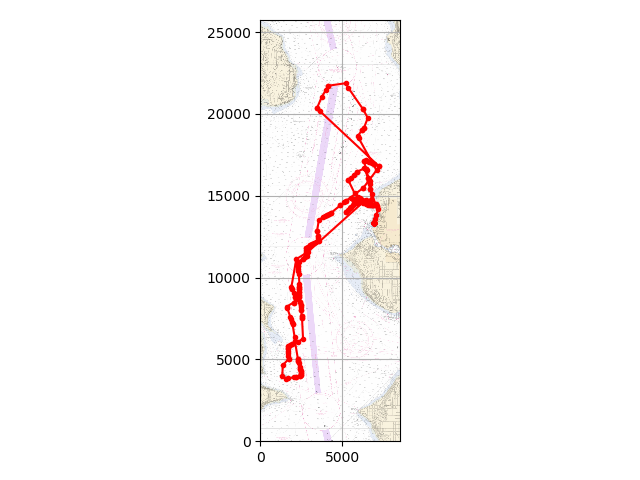

In [68]:
ch = c.plot_chart(cdf)
c.draw_track(cdf, ch, color='red', marker='.')

## Mostly There

Success!  Mostly.

First some observations.  This data is quite different from the race logs that are generated from the boat logs:

- There are only 4 "instruments": lat/lon/sog/cog
  - And currently sog/cog are ignore (see below)
- The rows are not generated at a synchronous fixed frequency.  Race logs are generated at 10Hz.  This data is processed so that rows are asynchronous, and are *event driven*.  There is one row per AIS message.

In fact this data is **very low frequency**.  There is approximately one row every 30 seconds (rather than 10 per second). Zooming into this data shows that this is just barely sufficient to show how the boat moves.  In particularly at the north "mark" the rounding is very coarse.

We can use COG/SOG to improve the quality of the track.  COG/SOG provides additional information about the track (speed and direction of travel).  From a mathematical standpoint these two numbers *double* the information that we have the track (rather than 2 observations we have 4).  COG/SOG are in fact the derivative of the track.

We can create a higher quality track by using the fitting a spline to the available data, and if we use a cubic spline we can include the derivatives as well.  The resulting smooth curve will fit the lat/lon coordinates **and** the COG/SOG.

<IPython.core.display.Javascript object>


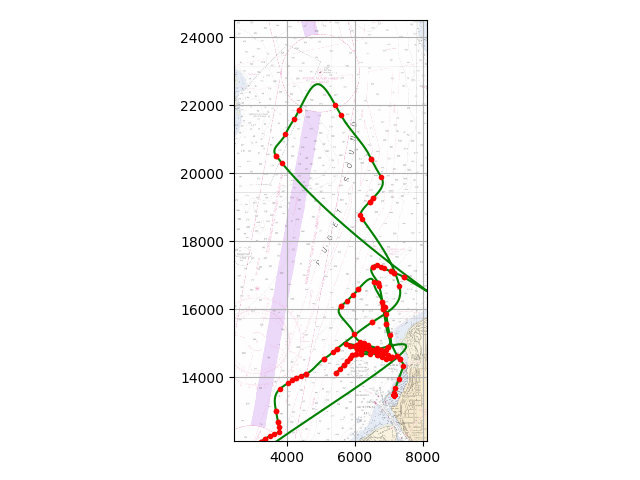

In [72]:
def fit_spline(df, plot=False):
    basetime = df.row_times.min()
    # Get the times, in seconds.
    x = np.array((df.row_times - basetime) / pd.Timedelta('1s'))
    # The dependent variable is position.  Use map position rather than lat/lon
    y = np.vstack(G.MAP(np.asarray(df.longitude), np.asarray(df.latitude))).T
    # Decompose the derivative into two components, north and east
    vog_north = df.sog * p.cos_d(df.cog)
    vog_east = df.sog * p.sin_d(df.cog)
    # Combine into a single matrix
    dy = np.vstack((vog_east, vog_north)).T

    # Compute spline
    cubic_spline = scipy.interpolate.CubicHermiteSpline(x, y, dy)

    # Create a new set of spline points, every 5 seconds.
    x_new = np.linspace(x.min(), x.max(), int((x.max() - x.min())/5))
    loc_new = cubic_spline(x_new)
    # Convert back to lat/lon
    lon_new, lat_new = G.MAP(loc_new[:,0], loc_new[:,1], inverse=True)

    # datetime conversions (painful)
    datetime64 = np.datetime64(basetime.tz_convert('UTC').tz_localize(None))
    time_new = datetime64 + x_new * pd.Timedelta('1s')

    # New DataFrame
    ndf = pd.DataFrame(dict(row_times=time_new, latitude = lat_new, longitude = lon_new))
    ndf.row_times = ndf.row_times.dt.tz_localize('UTC').dt.tz_convert('US/Pacific')
    # Current GPX needs an altitude, make one up!
    ndf['altitude'] = 0
    if plot:
        ch = c.plot_chart(ndf)
        c.draw_track(ndf, ch)
        c.draw_track(df, ch, color='red', linestyle = 'None', marker='.')
    return ndf

sdf = fit_spline(cdf, True)

### Finally

New spline results are much better.  The tacks are still a bit strange (e.g. some tacks are long and smooth rather than sharp).  But the tracks are much more realistic.

### GPX conversion

Finally some simple code to generate the GPX file (which can be uploaded to RaceQs).


In [76]:
import importlib
importlib.reload(ais_process)

<module 'ais_process' from '/Users/viola/GDrive/Sailboat/Code/Python/sailing/ais_process.py'>

In [80]:
import ais_process

json_path = p.json_from_matching_named_file("2020-04-16")
df_all = ais_process.json_to_ais_data_frame(json_path, None)  # 100000)


2020-04-17 10:51:49,949|INFO|json_from_named_file| 2020-04-16_14:54.log.gz: Creating JSON
2020-04-17 10:51:49,950|INFO|json_from_named_file| File /tmp/2020-04-16_14:54.json exists, skipping.
2020-04-17 10:51:49,951|INFO|ais_dataframes| Processed 0 json lines.
2020-04-17 10:51:49,953|INFO|ais_dataframes| Found GNSS record at 2020-04-16T21:54:32+00:00
2020-04-17 10:51:49,953|INFO|ais_dataframes| Delta time is 15 days, 8:37:24.968000.
2020-04-17 10:51:52,497|INFO|ais_dataframes| Processed 500000 json lines.
2020-04-17 10:51:55,075|INFO|ais_dataframes| Processed 1000000 json lines.
2020-04-17 10:51:57,574|INFO|ais_dataframes| Processed 1500000 json lines.
2020-04-17 10:52:00,184|INFO|ais_dataframes| Processed 2000000 json lines.


<IPython.core.display.Javascript object>


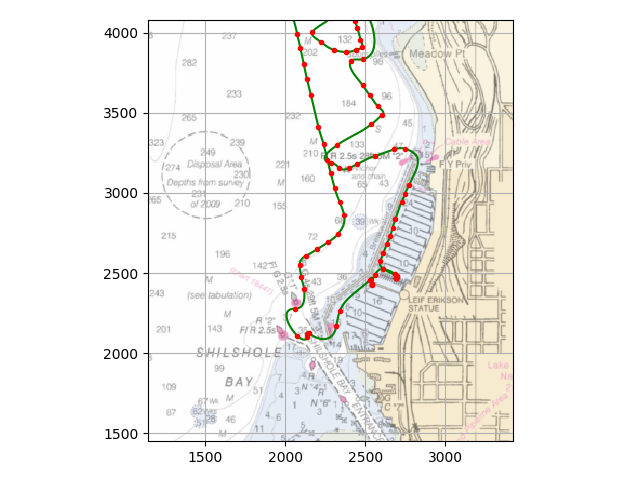

In [96]:
bdf = df_all[df_all.name=='CREATIVE']
ndf = bdf["name user_id longitude latitude cog sog timestamp row_times".split()]
cdf = ais_process.clean_ais_df(ndf)
sdf = ais_process.fit_spline(cdf, True)


In [98]:
ais_process.ais_df_to_gpx(sdf, "/Users/viola/tmp/foo.gpx")

2020-04-17 11:00:39,964|INFO|ais_df_to_gpx| Writing GPX result to /Users/viola/tmp/foo.gpx
